In [76]:
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

%matplotlib inline

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
PROCESSED_DATA_FILE = './../data/project_brazil/processed.csv'

In [31]:
RANDOM_STATE = 14

---

Загрузим предварительно обработанные данные.

In [5]:
df = pd.read_csv(PROCESSED_DATA_FILE)
print('Размер предварительно обработанного датасета: {}'.format(df.shape))

Размер предварительно обработанного датасета: (1407984, 31)


In [6]:
df.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 11:00:00,2007-11-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 12:00:00,2007-11-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 13:00:00,2007-11-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-14 01:00:00,2007-11-14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-14 02:00:00,2007-11-14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

Посмотрим на основную информацию о датасете.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407984 entries, 0 to 1407983
Data columns (total 31 columns):
wsid    1407984 non-null int64
wsnm    1407984 non-null object
elvt    1407984 non-null float64
lat     1407984 non-null float64
lon     1407984 non-null float64
inme    1407984 non-null object
city    1407984 non-null object
prov    1407984 non-null object
mdct    1407984 non-null object
date    1407984 non-null object
yr      1407984 non-null int64
mo      1407984 non-null int64
da      1407984 non-null int64
hr      1407984 non-null int64
prcp    1407984 non-null float64
stp     1407984 non-null float64
smax    1407984 non-null float64
smin    1407984 non-null float64
gbrd    768612 non-null float64
temp    1407983 non-null float64
dewp    1407973 non-null float64
tmax    1407984 non-null float64
dmax    1407965 non-null float64
tmin    1407981 non-null float64
dmin    1407968 non-null float64
hmdy    1407984 non-null float64
hmax    1407980 non-null float64
hmin    14079

---

Посмотрим на характеристики распределения категориальных признаков. Сразу приведем целочисленные признаки **wsid, yr, mo, da, hr** (которые являются категориальными) к строковому типу для корректной обработки методом describe().

In [8]:
int_features = ['wsid', 'yr', 'mo', 'da', 'hr']

for feat in int_features:
    df[feat] = df[feat].astype('str')
    
df.describe(exclude=['float64']).T

,count,unique,top,freq
wsid,1407984,122,418,48024
wsnm,1407984,122,MOELA,48024
inme,1407984,121,ZZZ3,48024
city,1407984,117,Rio de Janeiro,59186
prov,1407984,4,MG,526450
mdct,1407984,129258,2013-06-25 18:00:00,111
date,1407984,5680,2012-01-01,1481
yr,1407984,17,2011,143598
mo,1407984,12,1,167669
da,1407984,31,16,49439


<p>В выборке представлены 4 провинции и 177 городов. Аномальных значений в дате и времени нет. По описанию и практически совпадающим числам уникальных значений признаков **wsid**, **wsnm** и **inme** можно предположить, что данные признаки дублируют друг друга. Проверим это предположение.
<p>Идея состоит в следующем. Используя метод *groupby()*, можно сгруппировать значения одного признака по уникальным значениям другого. Затем с помощью метода *describe()* можно посмотреть на число уникальных значений второго признака в группах. Если на всех позициях стоят единицы, то можно утверждать о полном соответствии в значениях двух признаков.

In [156]:
wsid_groupedby_wsnm_descr = df.groupby('wsnm')['wsid'].describe()
wsid_wsnm_non_unique = wsid_groupedby_wsnm_descr[wsid_groupedby_wsnm_descr['unique'] != 1].shape[0]
print('Число несоответствий между признаками wsid и wsnm: {}'.format(wsid_wsnm_non_unique))

wsid_groupedby_inme_descr = df.groupby('inme')['wsid'].describe()
wsid_inme_non_unique = wsid_groupedby_inme_descr[wsid_groupedby_inme_descr['unique'] != 1].shape[0]
print('Число несоответствий между признаками wsid и inme: {}'.format(wsid_inme_non_unique))

Число несоответствий между признаками wsid и wsnm: 0
Число несоответствий между признаками wsid и inme: 1


Рассмотрим несоответствие детальней. Найдем значение **inme** той станции, по которой происходят расхождения, и посмотрим на уникальные значения координат, соответствующие ей.

In [157]:
non_unique_inme = wsid_groupedby_inme_descr[wsid_groupedby_inme_descr['unique'] != 1].index[0]

print(df[df['inme'] == non_unique_inme]['lat'].value_counts())
print()
print(df[df['inme'] == non_unique_inme]['lon'].value_counts())

-22.041647    18664
Name: lat, dtype: int64

-41.051871    18664
Name: lon, dtype: int64


Видно, что координаты этой проблемной станции принимают во всем датасете лишь одно значение. Значит, предположение о дублировании друг друга признаками **wsid, wsnm, inme** оказывается верным.

---

Выделим вещественные признаки и посмотрим на характеристики их распределения.

In [9]:
df.describe(include=['float64']).T

,count,mean,std,min,25%,50%,75%,max
elvt,1407984.0,593.423665,451.779265,0.000000,189.000000,573.000000,875.000000,1758.000
lat,1407984.0,-20.163774,4.593603,-24.962819,-22.589806,-21.338432,-19.532768,0.000
lon,1407984.0,-43.647082,8.730950,-56.677323,-47.585552,-44.835600,-42.622413,0.000
prcp,1407984.0,0.936654,2.923291,0.000000,0.000000,0.000000,0.600000,100.000
stp,1407984.0,525.744524,471.432826,0.000000,0.000000,895.100000,949.800000,1049.900
smax,1407984.0,525.155668,471.643990,0.000000,0.000000,895.100000,950.000000,1049.900
smin,1407984.0,524.825494,471.337439,0.000000,0.000000,894.400000,949.400000,1050.000
gbrd,768612.0,342.264637,669.663507,0.000000,0.000000,0.210000,375.053250,5552.683
temp,1407983.0,11.309906,10.461438,-3.400000,0.000000,15.700000,20.800000,41.000
dewp,1407973.0,9.886877,9.264952,-10.000000,0.000000,13.500000,18.800000,37.400


Можно сделать предварительные выводы по признакам:<br>
- **elvt** (высота) - значения характеристик скорее всего не содержат выбросов из-за ошибок измерений, или их число мало; возможно сделать проверку, используя геосервисы.
- **lat, lon** (координаты) - присутствуют выбросы в виде нулевых значений координат (все указанные в выборке регионы не паресекаются экватором или нулевым меридианом)
- **prcp** (осадки, целевой признак) - хочется верить, что ошибок измерений нет, иначе у нас вопросы к разметке данных; более 50% данных содержат информацию об отсутствии осадков, а 75% - об отсутствии или незначительных осадках
- **stp, smax, smin** (показатели давления) - явно просматриваются выбросы из-за ошибок измерений в виде нулевых значений, причем их более 25%
- **gbrd** (солнечное излучение) - с этим признакам вообще все плохо. Почти 50% в выборке у этого признака - пропуски. У оставшихся значений более 50% данных содержат нулевые или близкие к нулю выбросы. Выбросы также наблюдаются в виде максимальных значений, в 6 раз превышающих средний показатель солнечного излучения для жарких пустынных мест (ссылки на справочные источники информации будут даны в конце исследования)
- **temp, dewp, tmax, dmax, tmin, dmin** (температурные показатели) - значения скорее всего не содержат значительного числа ошибок измерений
- **hmdy, hmax, hmin** (показатели влажности) - более 25% данных содержат ошибки измерений в виде нулевых значений
- **wdsp, wdct, gust** (показатели ветра) - значения скорее всего не содержат значительного числа ошибок измерений

---

Посомтрим на количество пропусков данных для признаков и отобразим их в порядке убывания.

In [10]:
null_counts = df.isnull().sum()
null_counts[null_counts != 0].sort_values(ascending=False)

gbrd    639372
wdsp     72563
gust     22082
dmax        19
hmin        17
dmin        16
dewp        11
hmax         4
tmin         3
temp         1
dtype: int64

---

Из описания датасета можно увидеть, что признаки **mdct** (дата и время наблюдения) и **date** (дата наблюдения) избыточны, их полностью заменяют следующие признаки: **date, yr, mo, da, hr** (дата, год, месяц, день, час соответственно). Сконвертируем тип признаков **mdct** и **date** во внутренний тип pandas.datetime и проверим, что значения этих признаков соответствуют друг другу.

In [11]:
df['mdct'] = df['mdct'].apply(pd.to_datetime)
df['date'] = df['date'].apply(pd.to_datetime)

In [12]:
def datetime_accordance_check(row):
    return ((row['yr'] == row['mdct'].year) & (row['yr'] == row['date'].year) & 
            (row['mo'] == row['mdct'].month) & (row['mo'] == row['date'].month) & 
            (row['da'] == row['mdct'].day) & (row['da'] == row['date'].day) & 
            (row['hr'] == row['mdct'].hour))

df.apply(datetime_accordance_check, axis=1).value_counts()

False    1407984
dtype: int64

Видим, что рассматриваемые признаки полностью соответствуют друг другу. Избыточные признаки можно будет удалить из датасета.

---

Рассмотрим корреляцию вещественных признаков, исключая целевой. Отобразим распределение и топ-20 коррелирующих пар признаков по двум методам: Пирсона и Спирмана (оценивающие силу линейной и монотонной взаимосвязей соответственно).

In [13]:
numeric_columns = [col for col in df if (df[col].dtype == 'float64')]

pearson_corr = df[numeric_columns].corr(method='pearson')
spearman_corr = df[numeric_columns].corr(method='spearman')

In [14]:
no_target_unique_pearson_corr = dict()
no_target_unique_spearman_corr = dict()

for (row, r_name) in enumerate(pearson_corr.index):
    for (col, c_name) in enumerate(pearson_corr.columns[row+1:]):
        if('prcp' in [r_name, c_name]):
            continue
        no_target_unique_pearson_corr['{}-{}'.format(r_name, c_name)] = abs(pearson_corr.iloc[row, col])
        
for (row, r_name) in enumerate(spearman_corr.index):
    for (col, c_name) in enumerate(spearman_corr.columns[row+1:]):
        if('prcp' in [r_name, c_name]):
            continue
        no_target_unique_spearman_corr['{}-{}'.format(r_name, c_name)] = abs(spearman_corr.iloc[row, col])

pearson_corr_df = pd.DataFrame(sorted(no_target_unique_pearson_corr.items(), key=operator.itemgetter(1), reverse=True))
pearson_corr_df.columns = ['', 'pearson corr']

spearman_corr_df = pd.DataFrame(sorted(no_target_unique_spearman_corr.items(), key=operator.itemgetter(1), reverse=True))
spearman_corr_df.columns = ['', 'spearman corr']

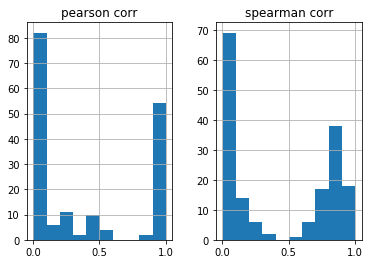

In [15]:
corr_df = pd.concat([pearson_corr_df, spearman_corr_df], axis=1)
corr_df.hist()
plt.show()

In [16]:
corr_df = pd.concat([pearson_corr_df.head(20), spearman_corr_df.head(20)], axis=1)
corr_df

,,pearson corr,,spearman corr
0,elvt-lat,1.000000,elvt-lat,1.000000
1,lon-smax,1.000000,lon-smax,1.000000
2,stp-dewp,1.000000,stp-dewp,1.000000
3,smax-dmax,1.000000,smax-dmax,1.000000
4,smin-dmin,1.000000,smin-dmin,1.000000
5,gbrd-hmax,1.000000,gbrd-hmax,1.000000
6,temp-wdsp,1.000000,temp-wdsp,1.000000
7,dewp-gust,1.000000,dewp-gust,1.000000
8,smax-tmin,0.999967,smax-tmin,0.999931
9,smin-tmin,0.999967,smin-tmin,0.999931


Видим, что оба метода на топ-результатах дают очень схожие показатели. Можно предположить, что корреляция между этими признаками есть, и взаимосвязь линейна. Но зависимость не объясняется физической природой признаков.

---

Рассмотри корреляцию с целевым признаком.

In [17]:
target_pearson_corr = dict(pearson_corr.apply(abs).loc['prcp', :])
target_pearson_corr.pop('prcp')

target_spearman_corr = dict(spearman_corr.apply(abs).loc['prcp', :])
target_spearman_corr.pop('prcp')

target_pearson_corr_df = pd.DataFrame(sorted(target_pearson_corr.items(), key=operator.itemgetter(1), reverse=True))
target_pearson_corr_df.columns = ['', 'pearson corr']

target_spearman_corr_df = pd.DataFrame(sorted(target_spearman_corr.items(), key=operator.itemgetter(1), reverse=True))
target_spearman_corr_df.columns = ['', 'spearman corr']

In [18]:
target_corr_df = pd.concat([target_pearson_corr_df, target_spearman_corr_df], axis=1)
target_corr_df

,,pearson corr,,spearman corr
0,gust,0.382044,hmdy,0.796693
1,hmdy,0.305894,hmax,0.794980
2,hmax,0.303327,hmin,0.769132
3,dmax,0.301448,gust,0.761979
4,dewp,0.296092,wdsp,0.745568
5,dmin,0.292986,dewp,0.745378
6,tmax,0.287871,dmin,0.744746
7,hmin,0.282092,dmax,0.744268
8,smax,0.278865,wdct,0.712490
9,smin,0.278684,smax,0.683713


Тут мы уже не наблюдаем схожесть в значениях коэффициентов корреляции. На оценку по методу Пирсона скорее всего повлияла ненормальность распределения, а по методу Спирмана вероятно, что оценки завышены. В любом случае, можно говорить о некоторой монотонной зависимости целевого признака от ряда других, некоторые объясняются физической природой признаков (например, осадки от влажности и точки росы).

---

Наконец, посмотрим на распределение целевого признака. Построим график в разных масштабах оси ординат.

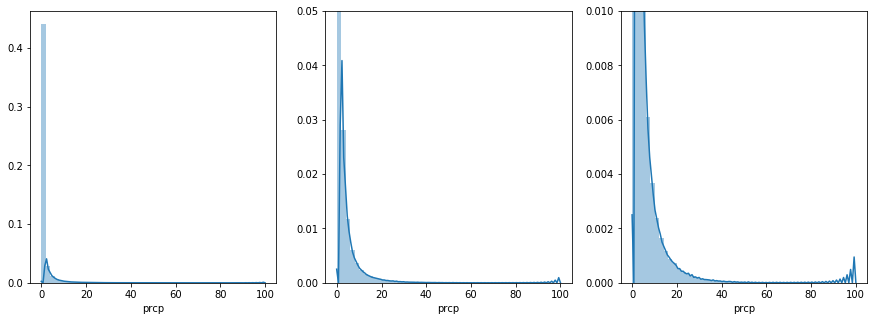

In [26]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.distplot(df['prcp'], ax=axes[0])

sns.distplot(df['prcp'], ax=axes[1])
axes[1].set_ylim(0, 0.05)

sns.distplot(df['prcp'], ax=axes[2])
axes[2].set_ylim(0, 0.01)

plt.show()

Очевидно, что распределение целевого признака далеко от номрального. Тем не менее, проведем статистические тесты на нормальность и скошенность распределения. Для оценки критерия Шапиро-Уилка в модуле scipy.stats существует метод shapiro(). У него есть ограничение на размер выборки - 5000 (в документации указано, что при выборках большего размера точность p-value не гарантируется). Проведем 10 случайных взятий подвыборки заданного размера и найдем среднее значение p-value на этих разбиениях.

In [20]:
shapiro_p_values = []

for split_num in range(10):
    np.random.seed(RANDOM_STATE + split_num)
    rand_split = np.random.randint(0, df.shape[0], size=5000)
    shapiro_p_values.append(stats.shapiro(df.loc[rand_split, 'prcp'])[1])
    
print('Среднее значение p-value критерия Шапиро-Уилка на случайных разбиениях: {}'.format(np.mean(shapiro_p_values)))
print('Значение p-value теста на скошенность распределения: {}'.format(stats.skewtest(df['prcp'])[1]))

Среднее значение p-value критерия Шапиро-Уилка на случайных разбиениях: 0.0
Значение p-value теста на скошенность распределения: 0.0


Полученное среднее p-value критерия Шапиро-Уилка меньше уровня значимости в 0.05, значит распределение не нормальное. Тест на скошенность распределения также не прошел.

Посмотрим внимательней на правый "хвост" распределения.

In [21]:
df[df['prcp'] > 75]['prcp'].value_counts().iloc[-25:]

78.4     3
77.6     2
76.2     2
77.8     1
81.2     1
79.8     1
85.4     1
75.8     1
96.8     1
75.2     1
77.0     1
89.0     1
100.0    1
Name: prcp, dtype: int64

Осадки интенсивностью в районе 100 мм/час - это очень сильные ливни. И хоть такие наблюдения значимы, но их слишком мало в общей массе для какого-то вклада в модель. Выполним фильтрацию нашей целевой переменной по 99% квантилю, чтобы избавиться от таких экстремальных единичных значений.

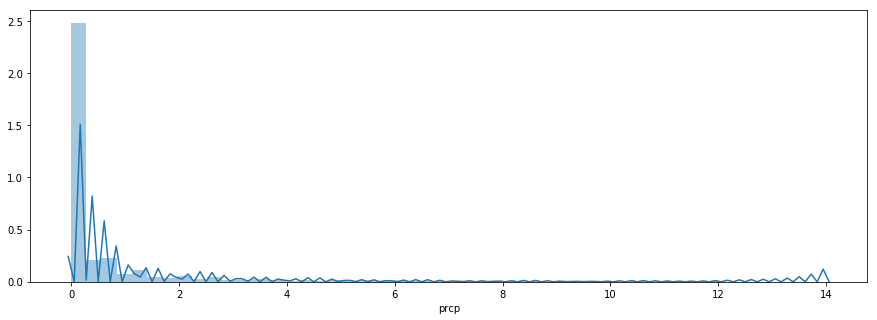

In [27]:
prcp_quantile = df['prcp'].quantile(0.99)
prcp_filtered = df[df['prcp'] < prcp_quantile]['prcp']

plt.figure(figsize=(15, 5))
sns.distplot(prcp_filtered)

<p>После фильтрации по квантилю обнаружилась следующая особенность целевого признака - он принимает дискретные значения (видимо, связанные с ограничениями на измерения в погодных станциях). 
<p>Учитывая все эти факты, принимаем решение перейти от казалось бы предполагаемой задачи регрессии к задаче многоклассовой классификации. Подчерпнув информацию о принятой классификации интенсивности дождей (точнее, об отсутствии единой таковой), выделим "на глаз" следующие классы целевой переменной.
- Отсутствие осадков: $prcp = 0.0$
- Небольшой дождь: $prcp\in(0.0; 1.2]$
- Умеренный дождь: $prcp\in(1.2; 2.5]$
- Сильный дождь: $prcp > 2.5$